# dataset
- downloaded at: https://public.opendatasoft.com/explore/dataset/georef-germany-postleitzahl/export/
- made available by: https://www.suche-postleitzahl.org/
- based on data from: https://www.openstreetmap.org/#map=4/48.25/11.29
- provided under [Open Data Commons Open Database License (ODbL) v1.0](https://opendatacommons.org/licenses/odbl/1-0/)


In [91]:
import pandas as pd
from geopy.distance import geodesic
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


def plot_map(lats, lons):
    # create map 
    map_projection = 'merc'
    _, ax = plt.subplots(figsize=(10, 6))
    map = Basemap(projection=map_projection, llcrnrlat=min(lats) - 1, urcrnrlat=max(lats) + 1,
                llcrnrlon=min(lons) - 1, urcrnrlon=max(lons) + 1, resolution='i', ax=ax)
    map.drawcoastlines()
    map.drawcountries()

    x, y = map(lons, lats)
    map.scatter(x, y, color='red', s=1)
    plt.show()

In [94]:
df_zip_coords = pd.read_excel("georef-germany-postleitzahl.xlsx")  # source: see above
df_zip_coords.head(3)
df_zip_coords["lat"] = df_zip_coords["geo_point_2d"].apply(lambda x: float(x.split(",")[0]))
df_zip_coords["lng"] = df_zip_coords["geo_point_2d"].apply(lambda x: float(x.split(",")[1][1:]))
df_zip_coords = df_zip_coords[["Name", "lng", "lat"]]
df_zip_coords.columns = ["zip", "lng", "lat"]
df_zip_coords.tail(2)

,zip,lng,lat
8932,56321,7.598982,50.272945
8933,56271,7.598612,50.499046


In [102]:
df_zip_coords["zip_str"] = df_zip_coords["zip"].apply(lambda x: str(x) if x >= 10_000 else "0" + str(x))
df_zip_coords["zip_three_str"] = df_zip_coords["zip_str"].apply(lambda x: x[:3])
df_zip_coords.head(2)

,zip,lng,lat,zip_str,zip_two_str,zip_three_str
0,58099,7.487858,51.400203,58099,58,580
1,44534,7.512674,51.631493,44534,44,445


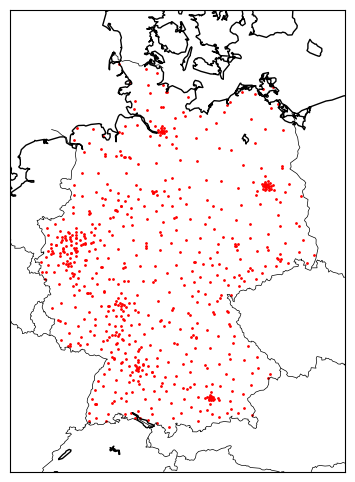

In [104]:
df_zip_three = df_zip_coords.groupby("zip_three_str")[["lng", "lat"]].mean()

plot_map(lats=df_zip_three["lat"], lons=df_zip_three["lng"])

In [112]:
import numpy as np

lats = df_zip_three["lat"]
lngs = df_zip_three["lng"]
dist_mat = np.zeros((len(df_zip_three), len(df_zip_three)))
for i in range(len(df_zip_three)):
    for j in range(i + 1, len(df_zip_three)):
        dist = geodesic((lats[i], lngs[i]), (lats[j], lngs[j])).kilometers
        dist_mat[i, j] = dist
        dist_mat[j, i] = dist
df_dists = pd.DataFrame(data=np.round(dist_mat).astype(int), index=df_zip_three.index.values, columns=df_zip_three.index.values)

C:\Users\milan\AppData\Local\Temp\ipykernel_5688\3552067940.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist = geodesic((lats[i], lngs[i]), (lats[j], lngs[j])).kilometers


note: some zip codes like 05xxx, 11xxx, 43xxx and 62xxx [don't exist](https://www.reddit.com/r/de/comments/p63p5i/warum_gibt_es_nicht_eine_05_postleitzahl/?rdt=35866)

In [114]:
# coarse distance hamburg-berlin:
print("some coarse distances:")
print("hamburg-berlin:", df_dists["221"]["101"], "km")
print("munich-bremen:", df_dists["281"]["803"], "km")

some coarse distances:
hamburg-berlin: 248 km
munich-bremen: 584 km
